Source: https://github.com/willwillis/python-nlp-sentiment

Vader Sentiment Analysis: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f#:~:text=The%20Compound%20score%20is%20a,1%20(most%20extreme%20positive).&text=The%20compound%20score%20turns%20out,a%20very%20high%20positive%20sentiment.

In [12]:
from newsapi_help_func import *
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from string import punctuation

# Expand the default stop words list if necessary
nltk.download('wordnet')
nltk.download('vader_lexicon')

import os
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# logging (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to /Users/ridwan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ridwan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# News Headlines Sentiment

Use the news api to pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [18]:
topics = ['Bitcoin', 'Ethereum','Cardano']
btc_sentiment = get_sentiments_on_topic(topics[0])
btc_df = sentiment_to_df(btc_sentiment)
display(btc_df.head()[['text','source','url']])
display("btc_df.describe()")
display(btc_df.describe())

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text  \
date                                                            
2020-10-12  By Reuters Staff\r\nLONDON (Reuters) - Bank of...   
2020-10-12  The sale and promotion of derivatives of bitco...   
2020-10-12  October\r\n12, 2020\r\n2 min read\r\nThis arti...   
2020-10-12  By Reuters Staff\r\nLONDON (Reuters) - Bank of...   
2020-10-14  Portions of the global economy melted down in ...   

                      source  \
date                           
2020-10-12           Reuters   
2020-10-12      The Next Web   
2020-10-12      Entrepreneur   
2020-10-12           Reuters   
2020-10-14  Business Insider   

                                                          url  
date                                                           
2020-10-12  https://www.reuters.com/article/us-britain-boe...  
2020-10-12  https://thenextweb.com/hardfork/2020/10/12/her...  
2020-10-12        https://www.entrepreneur.com/article/357644  
2020-10-12  https://uk.reuters.com/article/us-britain-boe-...  
2020-10-14  https://www.businessinsider.com/grayscale-inve...

'btc_df.describe()'

compound   positive    neutral   negative  normalized
count  96.000000  96.000000  96.000000  96.000000   96.000000
mean    0.091139   0.064698   0.891031   0.044271    0.156250
std     0.478612   0.072731   0.083153   0.070976    0.862409
min    -0.875000   0.000000   0.703000   0.000000   -1.000000
25%    -0.158500   0.000000   0.828000   0.000000   -1.000000
50%     0.000000   0.056000   0.893000   0.000000    0.000000
75%     0.510600   0.113000   0.956000   0.075500    1.000000
max     0.946800   0.297000   1.000000   0.263000    1.000000

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive). 

Positive Sentiment: Compound Score >= 0.05

Neutral Sentiment: Compound Score > -0.05 and Compound Score < 0.05

Negative Sentiment: Compound Score <= -0.05


In [15]:
# btc_df.shape

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(96, 8)

In [4]:
eth_sentiment = get_sentiments_on_topic(topics[1])
eth_df = sentiment_to_df(eth_sentiment)
display(eth_df.head())
display(eth_df.describe())

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text    source  \
date                                                                      
2020-10-04  With final preparations for the launch of Ethe...  CoinDesk   
2020-10-05  Visual representations of cryptocurrency Ether...    Forbes   
2020-10-05  CoinDesk is preparing for invest: ethereum eco...  CoinDesk   
2020-10-06  Ethereums highly anticipated 2.0 upgrade is po...  CoinDesk   
2020-10-06  MetaMask announced a new feature Tuesday: toke...  CoinDesk   

                                                          url  compound  \
date                                                                      
2020-10-04                 https://www.coindesk.com/?p=520475    0.0000   
2020-10-05  https://www.forbes.com/sites/rorymurray/2020/1...    0.0000   
2020-10-05  https://www.coindesk.com/blockchain-bites-ethe...    0.6486   
2020-10-06  https://www.coindesk.com/coindesk-live-ethereu...    0.7430   
2020-10-06  https://www.coindesk.com/metamask-gets-into-th...    0.4215   

            positive  neutral  negative  normalized  
date                                                 
2020-10-04     0.000    1.000       0.0           0  
2020-10-05     0.000    1.000       0.0           0  
2020-10-05     0.150    0.850       0.0           1  
2020-10-06     0.229    0.771       0.0           1  
2020-10-06     0.091    0.909       0.0           1

compound   positive    neutral   negative  normalized
count  91.000000  91.000000  91.000000  91.000000   91.000000
mean    0.251602   0.078044   0.905890   0.016088    0.505495
std     0.352678   0.077650   0.081972   0.035017    0.689180
min    -0.631000   0.000000   0.626000   0.000000   -1.000000
25%     0.000000   0.000000   0.859000   0.000000    0.000000
50%     0.226300   0.072000   0.914000   0.000000    1.000000
75%     0.526700   0.111000   1.000000   0.000000    1.000000
max     0.944200   0.374000   1.000000   0.150000    1.000000

In [5]:
ada_sentiment = get_sentiments_on_topic(topics[2])
ada_df = sentiment_to_df(ada_sentiment)
display(ada_df.head())
display(ada_df.describe())

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text         source  \
date                                                                           
2020-10-04  Investors are concerned about the stability of...  Cointelegraph   
2020-10-04  eToro, the multi-asset platform with over 14 m...        newsBTC   
2020-10-05  Good afternoon, the S&amp;P 500 rose steadily ...     Bitcoinist   
2020-10-05  Bitcoin remains buoyant and is now approaching...     Bitcoinist   
2020-10-05  Bitcoin remains buoyant, and is now approachin...        newsBTC   

                                                          url  compound  \
date                                                                      
2020-10-04  https://cointelegraph.com/news/top-5-cryptocur...   -0.3612   
2020-10-04  https://www.newsbtc.com/2020/10/04/etoro-to-pr...    0.0000   
2020-10-05  https://bitcoinist.com/bitcoin-and-crypto-mark...    0.1531   
2020-10-05  https://bitcoinist.com/bitcoin-and-crypto-mark...   -0.3818   
2020-10-05  https://www.newsbtc.com/2020/10/05/crypto-roun...   -0.3818   

            positive  neutral  negative  normalized  
date                                                 
2020-10-04     0.000    0.932     0.068          -1  
2020-10-04     0.000    1.000     0.000           0  
2020-10-05     0.072    0.871     0.057           1  
2020-10-05     0.054    0.819     0.127          -1  
2020-10-05     0.054    0.819     0.127          -1

compound   positive    neutral   negative  normalized
count  61.000000  61.000000  61.000000  61.000000   61.000000
mean    0.122821   0.069787   0.893836   0.036377    0.163934
std     0.409276   0.074677   0.081721   0.050141    0.859851
min    -0.709600   0.000000   0.740000   0.000000   -1.000000
25%    -0.102700   0.000000   0.833000   0.000000   -1.000000
50%     0.000000   0.054000   0.893000   0.000000    0.000000
75%     0.476700   0.118000   0.959000   0.072000    1.000000
max     0.848100   0.250000   1.000000   0.187000    1.000000

### Questions:

Q: Which coin had the highest mean positive score?

A: **ADA**

Q: Which coin had the highest compound score?

A: **ETH**

Q. Which coin had the highest positive score?

A:  **???**

---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [6]:
# Create a new tokens column for bitcoin
btc_df_list = btc_df
btc_df_list["tokens"] = btc_df_list["text"].apply(tokenizer)
btc_df_list.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text         source  \
date                                                                           
2020-10-05  If there's one thing that John McAfee loves, i...       Mashable   
2020-10-06  By Reuters Staff\r\nLONDON (Reuters) - Britain...        Reuters   
2020-10-06  LONDON (Reuters) - Britains financial watchdog...        Reuters   
2020-10-07  Contents\r\n<ol><li>Preface</li><li>Introducti...  Vapor.network   
2020-10-07  Investors seeking to capitalize on the worlds ...   The Next Web   

                                                          url  compound  \
date                                                                      
2020-10-05  https://mashable.com/article/john-mcafee-sec-i...    0.6249   
2020-10-06  https://www.reuters.com/article/britain-crypto...   -0.2732   
2020-10-06  https://uk.reuters.com/article/uk-britain-cryp...   -0.7703   
2020-10-07                             https://vapor.network/    0.0000   
2020-10-07  https://thenextweb.com/hardfork/2020/10/07/esp...    0.5984   

            positive  neutral  negative  normalized  \
date                                                  
2020-10-05     0.184    0.744     0.072           1   
2020-10-06     0.066    0.840     0.094          -1   
2020-10-06     0.061    0.713     0.226          -1   
2020-10-07     0.000    1.000     0.000           0   
2020-10-07     0.129    0.871     0.000           1   

                                                       tokens  
date                                                           
2020-10-05  [there, one, thing, john, mcafee, love, bath, ...  
2020-10-06  [reuters, stafflondon, reuters, britain, finan...  
2020-10-06  [london, reuters, britain, financial, watchdog...  
2020-10-07  [contentsolliprefaceliliintroduction, lilihow,...  
2020-10-07  [investor, seeking, capitalize, world, rising,...

In [7]:
preprocess_sentiment(btc_df)
btc_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


text  \
date                                                            
2020-10-05  If there's one thing that John McAfee loves, i...   
2020-10-06  By Reuters Staff\r\nLONDON (Reuters) - Britain...   
2020-10-06  LONDON (Reuters) - Britains financial watchdog...   
2020-10-07  Contents\r\n<ol><li>Preface</li><li>Introducti...   
2020-10-07  Investors seeking to capitalize on the worlds ...   
...                                                       ...   
2020-11-03  (Reuters) - PayPal Holdings Inc PYPL.O beat Wa...   
2020-11-03  By Reuters Staff\r\nFILE PHOTO: Representation...   
2020-11-03  In stock-market shorthand, value investing is ...   
2020-11-03  On July 4, former child actor turned Bitcoin e...   
2020-11-03  Two young men from the eastern United States h...   

                       source  \
date                            
2020-10-05           Mashable   
2020-10-06            Reuters   
2020-10-06            Reuters   
2020-10-07      Vapor.network   
2020-10-07       The Next Web   
...                       ...   
2020-11-03            Reuters   
2020-11-03            Reuters   
2020-11-03   Business Insider   
2020-11-03       Fast Company   
2020-11-03  Krebs on Security   

                                                          url  compound  \
date                                                                      
2020-10-05  https://mashable.com/article/john-mcafee-sec-i...    0.6249   
2020-10-06  https://www.reuters.com/article/britain-crypto...   -0.2732   
2020-10-06  https://uk.reuters.com/article/uk-britain-cryp...   -0.7703   
2020-10-07                             https://vapor.network/    0.0000   
2020-10-07  https://thenextweb.com/hardfork/2020/10/07/esp...    0.5984   
...                                                       ...       ...   
2020-11-03  https://in.reuters.com/article/paypal-results-...    0.6597   
2020-11-03  https://www.reuters.com/article/us-crypto-curr...    0.0000   
2020-11-03  https://www.businessinsider.com/stock-market-i...    0.2023   
2020-11-03  https://www.fastcompany.com/90570581/brock-pie...    0.0000   
2020-11-03  https://krebsonsecurity.com/2020/11/two-charge...   -0.7430   

            positive  neutral  negative  normalized  \
date                                                  
2020-10-05     0.184    0.744     0.072           1   
2020-10-06     0.066    0.840     0.094          -1   
2020-10-06     0.061    0.713     0.226          -1   
2020-10-07     0.000    1.000     0.000           0   
2020-10-07     0.129    0.871     0.000           1   
...              ...      ...       ...         ...   
2020-11-03     0.157    0.843     0.000           1   
2020-11-03     0.000    1.000     0.000           0   
2020-11-03     0.124    0.801     0.075           1   
2020-11-03     0.000    1.000     0.000           0   
2020-11-03     0.095    0.681     0.224          -1   

                                                       tokens sentiment  
date                                                                     
2020-10-05  if there s one thing that john mcafee loves  i...  positive  
2020-10-06  by reuters staff\r\nlondon  reuters    britain...  negative  
2020-10-06  london  reuters    britains financial watchdog...  negative  
2020-10-07  contents\r\n ol  li preface  li  li introducti...  positive  
2020-10-07  investors seeking to capitalize on the worlds ...  positive  
...                                                       ...       ...  
2020-11-03   reuters    paypal holdings inc pypl o beat wa...  positive  
2020-11-03  by reuters staff\r\nfile photo  representation...  positive  
2020-11-03  in stock market shorthand  value investing is ...  positive  
2020-11-03  on july    former child actor turned bitcoin e...  positive  
2020-11-03  two young men from the eastern united states h...  negative  

[95 rows x 10 columns]

In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(btc_df['tokens'], btc_df['sentiment'], test_size=0.3, random_state=42)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


able  accepting  access  according  accounts  act  actor  adds  advantage  \
0     0          0       0          0         0    0      0     0          0   
1     0          0       0          0         0    0      0     0          0   
2     0          0       0          0         0    0      0     0          0   
3     0          0       0          0         0    0      0     0          0   
4     0          0       0          0         0    0      0     0          0   

   againadding  ...  worldwide  worth  year  years  yi  york  youll  young  \
0            0  ...          0      0     0      0   0     0      0      0   
1            0  ...          0      0     0      1   0     0      0      0   
2            0  ...          0      0     0      0   0     0      0      0   
3            0  ...          0      0     0      0   0     0      0      0   
4            0  ...          1      0     0      0   0     0      0      0   

   yuan  zoom  
0     0     0  
1     0     0  
2     0     0  
3     0     0  
4     0     0  

[5 rows x 654 columns]

In [10]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


able  able buy  able pay  able use  accepting  accepting cryptocurrencies  \
0     0         0         0         0          0                           0   
1     0         0         0         0          0                           0   
2     0         0         0         0          0                           0   
3     0         0         0         0          0                           0   
4     0         0         0         0          0                           0   

   access  access naked  according  according reporting  ...  york reuters  \
0       0             0          0                    0  ...             0   
1       0             0          0                    0  ...             0   
2       0             0          0                    0  ...             0   
3       0             0          0                    0  ...             0   
4       0             0          0                    0  ...             0   

   york state  youll  youll able  young  young men  yuan  yuan million  zoom  \
0           0      0           0      0          0     0             0     0   
1           0      0           0      0          0     0             0     0   
2           0      0           0      0          0     0             0     0   
3           0      0           0      0          0     0             0     0   
4           0      0           0      0          0     0             0     0   

   zoom videos  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 1585 columns]

### Classifying Using Logistic Regression

In [11]:
# Create a logistic regression model to use
lr = LogisticRegression()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


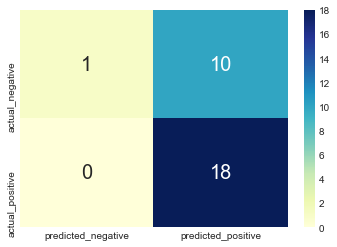

In [118]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

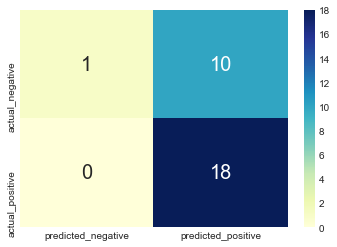

In [119]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [120]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

LogReg1  LogReg2
Accuracy     0.655    0.655
Precision    0.643    0.643
Recall       1.000    1.000
F1 Score     0.783    0.783

Comparing the two models, the second model has better accuracy, precision, recall, and f1 score.

### Classifying Using Naive Bayes

In [121]:
# Fit the first Naive Bayes model

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [122]:
# Fit the second Naive Bayes model

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

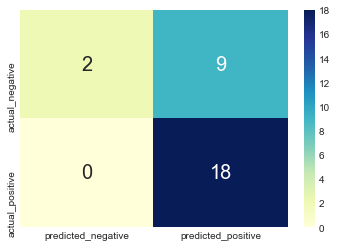

In [123]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

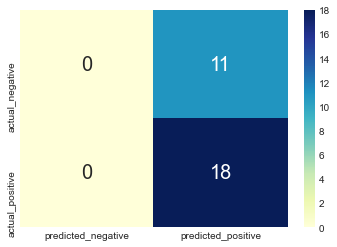

In [124]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [125]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

LogReg1  LogReg2    NB1    NB2
Accuracy     0.655    0.655  0.690  0.621
Precision    0.643    0.643  0.667  0.621
Recall       1.000    1.000  1.000  1.000
F1 Score     0.783    0.783  0.800  0.766

The second Logistic Regression model outperforms all other models.

### Try using TF-IDF instead of Count Vectorizer

In [126]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()

able  accepting  according  account  accounts  accusing  active  \
0  0.230494        0.0        0.0      0.0       0.0       0.0     0.0   
1  0.000000        0.0        0.0      0.0       0.0       0.0     0.0   
2  0.000000        0.0        0.0      0.0       0.0       0.0     0.0   
3  0.000000        0.0        0.0      0.0       0.0       0.0     0.0   
4  0.000000        0.0        0.0      0.0       0.0       0.0     0.0   

   activism  adds  advantage  ...  write  writes  year  years  yesterday   yi  \
0       0.0   0.0        0.0  ...    0.0     0.0   0.0    0.0        0.0  0.0   
1       0.0   0.0        0.0  ...    0.0     0.0   0.0    0.0        0.0  0.0   
2       0.0   0.0        0.0  ...    0.0     0.0   0.0    0.0        0.0  0.0   
3       0.0   0.0        0.0  ...    0.0     0.0   0.0    0.0        0.0  0.0   
4       0.0   0.0        0.0  ...    0.0     0.0   0.0    0.0        0.0  0.0   

   york  youll  youth  yuan  
0   0.0    0.0    0.0   0.0  
1   0.0    0.0    0.0   0.0  
2   0.0    0.0    0.0   0.0  
3   0.0    0.0    0.0   0.0  
4   0.0    0.0    0.0   0.0  

[5 rows x 693 columns]

In [127]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

able  able buy  able use  accepting  accepting cryptocurrencies  \
0  0.162187  0.178145       0.0        0.0                         0.0   
1  0.000000  0.000000       0.0        0.0                         0.0   
2  0.000000  0.000000       0.0        0.0                         0.0   
3  0.000000  0.000000       0.0        0.0                         0.0   
4  0.000000  0.000000       0.0        0.0                         0.0   

   according  according reporting  according reuters  account  \
0        0.0                  0.0                0.0      0.0   
1        0.0                  0.0                0.0      0.0   
2        0.0                  0.0                0.0      0.0   
3        0.0                  0.0                0.0      0.0   
4        0.0                  0.0                0.0      0.0   

   account initially  ...  york reuters  york state  youll  youll able  youth  \
0                0.0  ...           0.0         0.0    0.0         0.0    0.0   
1                0.0  ...           0.0         0.0    0.0         0.0    0.0   
2                0.0  ...           0.0         0.0    0.0         0.0    0.0   
3                0.0  ...           0.0         0.0    0.0         0.0    0.0   
4                0.0  ...           0.0         0.0    0.0         0.0    0.0   

   youth led  youth stronger  yuan  yuan analysts  yuan million  
0        0.0             0.0   0.0            0.0           0.0  
1        0.0             0.0   0.0            0.0           0.0  
2        0.0             0.0   0.0            0.0           0.0  
3        0.0             0.0   0.0            0.0           0.0  
4        0.0             0.0   0.0            0.0           0.0  

[5 rows x 1699 columns]

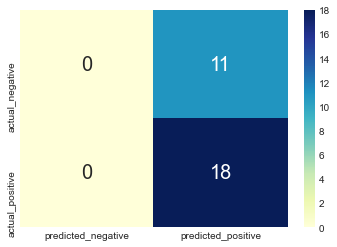

In [128]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

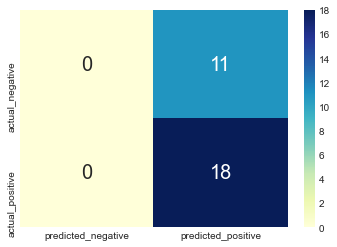

In [129]:
# Fit the second logistic regression on the TF-IDF data
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)
cm6 = conf_matrix(y_test, y_pred_tfidf2_lr)

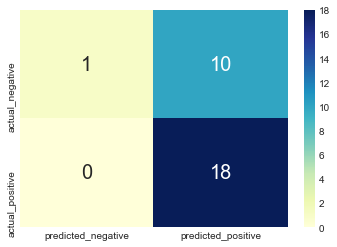

In [130]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

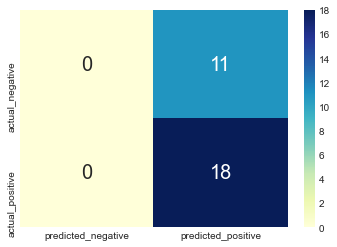

In [131]:
# Fit the second Naive Bayes model on the TF-IDF data
bnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_nb = bnb.predict(X_test_tfidf2)
cm8 = conf_matrix(y_test, y_pred_tfidf2_nb)

In [132]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm6, cm7, cm8)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results

LogReg1  LogReg2    NB1    NB2  LR1-TFIDF  LR2-TFIDF  NB1-TFIDF  \
Accuracy     0.655    0.655  0.690  0.621      0.621      0.621      0.655   
Precision    0.643    0.643  0.667  0.621      0.621      0.621      0.643   
Recall       1.000    1.000  1.000  1.000      1.000      1.000      1.000   
F1 Score     0.783    0.783  0.800  0.766      0.766      0.766      0.783   

           NB2-TFIDF  
Accuracy       0.621  
Precision      0.621  
Recall         1.000  
F1 Score       0.766

It looks like using TF-IDF, it didn't help our model

Overall, the second Logistic Regression model (using both unigrams and bigrams, and indicators instead of counts) seems to best classify positive and negative sentiment on Bitcoin.

## Topic Modeling with Matrix Factorization

### Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. Read up on the [documentation](https://scikit-learn.org/stable/modules/decomposition.html), which also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [134]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(2)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

array([0.16446009, 0.04494971])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ...
- Component 2 (topic 2) seems to be about ...

In [139]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word

able  accepting  according  account  accounts  accusing  active  \
component_1  0.002      0.001      0.003    0.001     0.003     0.002   0.001   
component_2  0.015      0.009      0.020    0.007     0.019     0.015   0.008   

             activism   adds  advantage  ...  write  writes   year  years  \
component_1     0.001  0.001      0.001  ...  0.001   0.001  0.003  0.002   
component_2     0.003  0.004      0.009  ...  0.005   0.008  0.024  0.010   

             yesterday     yi   york  youll  youth   yuan  
component_1      0.001  0.001  0.012  0.001  0.001  0.002  
component_2      0.002  0.011  0.082  0.008  0.005  0.018  

[2 rows x 693 columns]

In [140]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [141]:
display_topics(lsa, cv1.get_feature_names(), 5)


Topic  0
li, chars, reuters, ul, world

Topic  1
reuters, chars, bitcoin, london, paypal


The Vt matrix shows us the documents we started with, and how each document is made up of the # resulting topics. In this case:
- The first ### documents seem to be about ...
- The last ### documents seem to be about ...

In [144]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
Vt

component_1  component_2
tokens                                                                      
paypal has partnered with cryptocurrency compan...      0.27985      1.51835
in a week that covid   continued its invasion o...      0.15563      0.55637
london  reuters    paypal holdings inc s pypl o...      0.36623      2.14571
london  reuters    paypal holdings incs decisio...      0.36463      2.13317
us president donald trump and first lady melani...      0.15689      0.59547
...                                                         ...          ...
by reuters staff\r\nfile photo  representations...      0.64972      4.31379
the value of bitcoin spiked on wednesday after ...      0.36725      2.00316
biotech stocks continued to surge on wednesday ...      0.15985      0.62315
cryptocurrency supporters all around the world ...      0.27876      0.98486
paypal holdings inc  plans to allow customers t...      0.25835      1.36001

[67 rows x 2 columns]

Looking at cosine similarity, you can see that two documents both high in component 2 will have a similarity of 1, and two documents high in different components will have a similarity of 0.

In [145]:
cosine_similarity(Vt)

array([[1.        , 0.99590891, 0.99991268, ..., 0.99763156, 0.99562608,
        0.9999851 ],
       [0.99590891, 1.        , 0.99462781, ..., 0.9997657 , 0.99999526,
        0.99638733],
       [0.99991268, 0.99462781, 1.        , ..., 0.99663547, 0.99430451,
        0.99982565],
       ...,
       [0.99763156, 0.9997657 , 0.99663547, ..., 1.        , 0.99969434,
        0.99799217],
       [0.99562608, 0.99999526, 0.99430451, ..., 0.99969434, 1.        ,
        0.99612124],
       [0.9999851 , 0.99638733, 0.99982565, ..., 0.99799217, 0.99612124,
        1.        ]])

In [147]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

array([[1.  , 0.05, 0.18, 0.18, 0.04],
       [0.05, 1.  , 0.05, 0.05, 0.28],
       [0.18, 0.05, 1.  , 0.95, 0.05],
       [0.18, 0.05, 0.95, 1.  , 0.05],
       [0.04, 0.28, 0.05, 0.05, 1.  ]])

### Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 6 documents that contain many unique words (or features). The goal is to reduce those words down into 2 topics, so that each document can be represented as some combination of the 2 topics. We will be using NMF this time around.

In [148]:
nmf_model = NMF(2)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

The W matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:
- Component 1 (topic 1) seems to be about ###
- Component 2 (topic 2) seems to be about ###

In [149]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2"],
             columns = cv1.get_feature_names())
topic_word_nmf

able  accepting  according  account  accounts  accusing  active  \
component_1  0.000      0.000      0.000    0.000     0.000     0.000   0.000   
component_2  0.056      0.036      0.077    0.028     0.073     0.056   0.032   

             activism   adds  advantage  ...  write  writes   year  years  \
component_1     0.001  0.000      0.000  ...   0.00    0.00  0.000  0.001   
component_2     0.012  0.017      0.034  ...   0.02    0.03  0.091  0.040   

             yesterday     yi   york  youll  youth   yuan  
component_1      0.001  0.000  0.000  0.000  0.001  0.000  
component_2      0.009  0.042  0.314  0.029  0.020  0.068  

[2 rows x 693 columns]

In [150]:
display_topics(nmf_model, cv1.get_feature_names(), 10)


Topic  0
li, ul, chars, world, ol, benefits, web, preface, protocol, wide

Topic  1
reuters, chars, bitcoin, london, paypal, file, virtual, photo, staff, digital


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- The first document seems to be about ...
- The last document seems to be about ...
- Everything in between is a combination of the two

In [152]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2" ])
H

component_1  component_2
tokens                                                                      
paypal has partnered with cryptocurrency compan...      0.00283      0.40720
in a week that covid   continued its invasion o...      0.01296      0.15102
london  reuters    paypal holdings inc s pypl o...      0.00000      0.57417
london  reuters    paypal holdings incs decisio...      0.00000      0.57084
us president donald trump and first lady melani...      0.01160      0.16131
...                                                         ...          ...
by reuters staff\r\nfile photo  representations...      0.00000      1.15034
the value of bitcoin spiked on wednesday after ...      0.00295      0.53702
biotech stocks continued to surge on wednesday ...      0.01114      0.16867
cryptocurrency supporters all around the world ...      0.02432      0.26741
paypal holdings inc  plans to allow customers t...      0.00419      0.36500

[67 rows x 2 columns]

In [163]:
# Set categories
# categories = ['bitcoin', 'paypal', 'crypto']

# Download the training subset of the 20 NG dataset, with headers, footers, quotes removed
# Only keep docs from the 6 categories above
ng_train = X_train_cv1_df(subset='train', categories=categories, 
                                      remove=('headers', 'footers', 'quotes'))

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: 'DataFrame' object is not callable

## Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [157]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(67, 10)


In [158]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

(67, 10)


### Fit the Latent Dirichlet Allocation models

In [159]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

## pyLDAvis

Recall the # categories we extracted:

* ...
* ...

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [161]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: Object of type complex is not JSON serializable

---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [45]:
from collections import Counter
from nltk import ngrams

In [50]:
# Generate the Bitcoin N-grams where N=2
flat_btc_tokens = [item for sublist in btc_df_list.tokens.to_list() for item in sublist]
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

[(('char', 'reuters'), 14),
 (('char', 'london'), 11),
 (('london', 'reuters'), 11),
 (('new', 'york'), 9),
 (('york', 'reuters'), 9),
 (('central', 'bank'), 8),
 (('virtual', 'currency'), 7),
 (('char', 'paypal'), 7),
 (('paypal', 'holding'), 7),
 (('holding', 'inc'), 7),
 (('virtual', 'coin'), 7),
 (('photo', 'representation'), 6),
 (('digital', 'currency'), 6),
 (('customer', 'buy'), 6),
 (('buy', 'sell'), 6),
 (('reuters', 'paypal'), 6),
 (('world', 'largest'), 5),
 (('char', 'new'), 5),
 (('bitcoin', 'btc'), 5),
 (('reuters', 'stafffile'), 5)]

In [23]:
# Generate the Ethereum N-grams where N=2
flat_eth_tokens = [item for sublist in eth_df.tokens.to_list() for item in sublist]
eth_bigram_counts = Counter(ngrams(flat_eth_tokens, n=2))
eth_bigram_counts.most_common(20)

[(('char', 'bitcoin'), 6),
 (('decentralized', 'finance'), 6),
 (('digital', 'payment'), 6),
 (('customer', 'buy'), 6),
 (('finance', 'defi'), 5),
 (('cryptocurrency', 'market'), 5),
 (('char', 'paypal'), 5),
 (('paypal', 'holding'), 5),
 (('holding', 'inc'), 5),
 (('char', 'ethereum'), 4),
 (('bitcoin', 'btc'), 4),
 (('char', 'ethereums'), 4),
 (('company', 'char'), 4),
 (('invest', 'ethereum'), 4),
 (('digital', 'currency'), 4),
 (('payment', 'company'), 4),
 (('char', 'london'), 4),
 (('london', 'reuters'), 4),
 (('reuters', 'paypal'), 4),
 (('joined', 'cryptocurrency'), 4)]

In [24]:
# Generate the Cardano N-grams where N=2
flat_ada_tokens = [item for sublist in ada_df.tokens.to_list() for item in sublist]
ada_bigram_counts = Counter(ngrams(flat_ada_tokens, n=2))
ada_bigram_counts.most_common(20)

[(('bitcoin', 'btc'), 8),
 (('char', 'bitcoin'), 7),
 (('char', 'note'), 4),
 (('note', 'information'), 4),
 (('information', 'page'), 4),
 (('page', 'subject'), 4),
 (('subject', 'change'), 4),
 (('change', 'use'), 4),
 (('use', 'website'), 4),
 (('website', 'constitutes'), 4),
 (('constitutes', 'acceptance'), 4),
 (('acceptance', 'user'), 4),
 (('user', 'agreement'), 4),
 (('agreement', 'please'), 4),
 (('please', 'read'), 4),
 (('read', 'privacy'), 4),
 (('privacy', 'policy'), 4),
 (('policy', 'legal'), 4),
 (('legal', 'disclaimertrading'), 4),
 (('disclaimertrading', 'foreign'), 4)]

In [51]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [52]:
# Get the top 10 words for Bitcoin
token_count(flat_btc_tokens)

[('char', 96),
 ('reuters', 54),
 ('bitcoin', 36),
 ('cryptocurrency', 22),
 ('paypal', 19),
 ('digital', 17),
 ('u', 16),
 ('currency', 16),
 ('york', 14),
 ('virtual', 14)]

In [53]:
# Get the top 10 words for Ethereum
token_count(flat_eth_tokens)

NameError: name 'flat_eth_tokens' is not defined

In [28]:
# Get the top 10 words for Cardano
token_count(flat_ada_tokens)

[('char', 61),
 ('market', 14),
 ('bitcoin', 14),
 ('week', 12),
 ('btc', 10),
 ('ada', 9),
 ('price', 9),
 ('u', 8),
 ('level', 8),
 ('user', 7)]

# Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

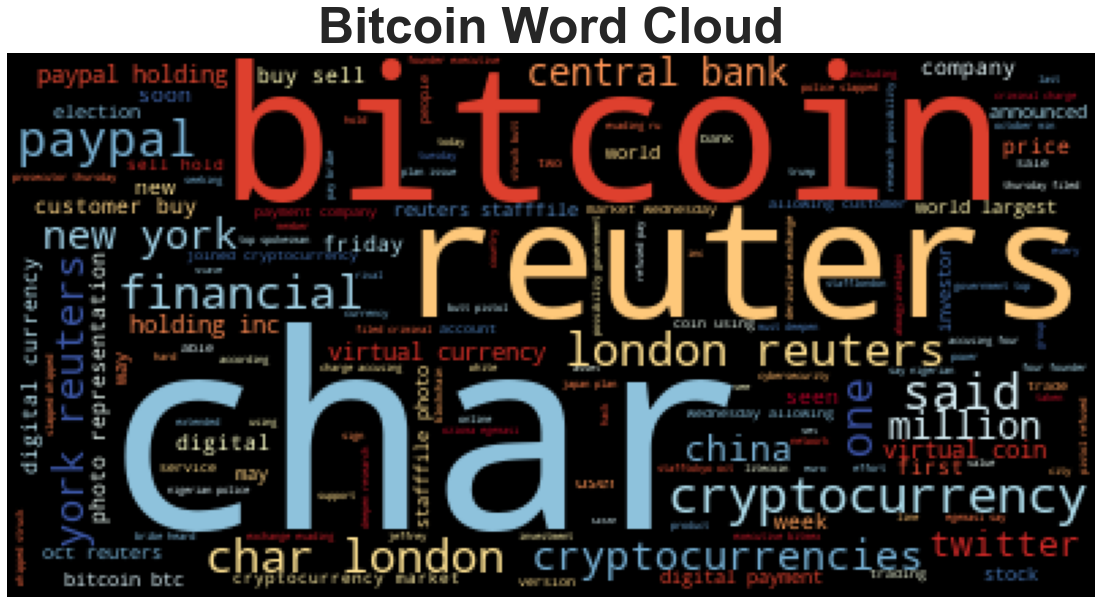

In [55]:
# Generate the Bitcoin word cloud
wordcloud = WordCloud(colormap="RdYlBu").generate(" ".join(flat_btc_tokens))
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.show()

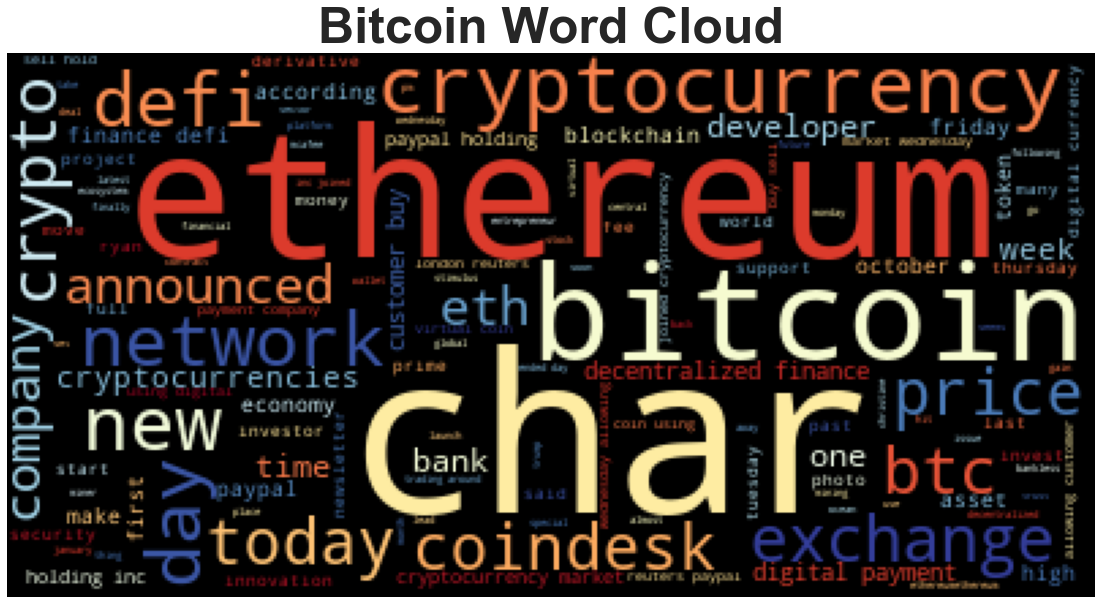

In [31]:
# Generate the Ethereum word cloud
wordcloud = WordCloud(colormap="RdYlBu").generate(" ".join(flat_eth_tokens))
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.show()

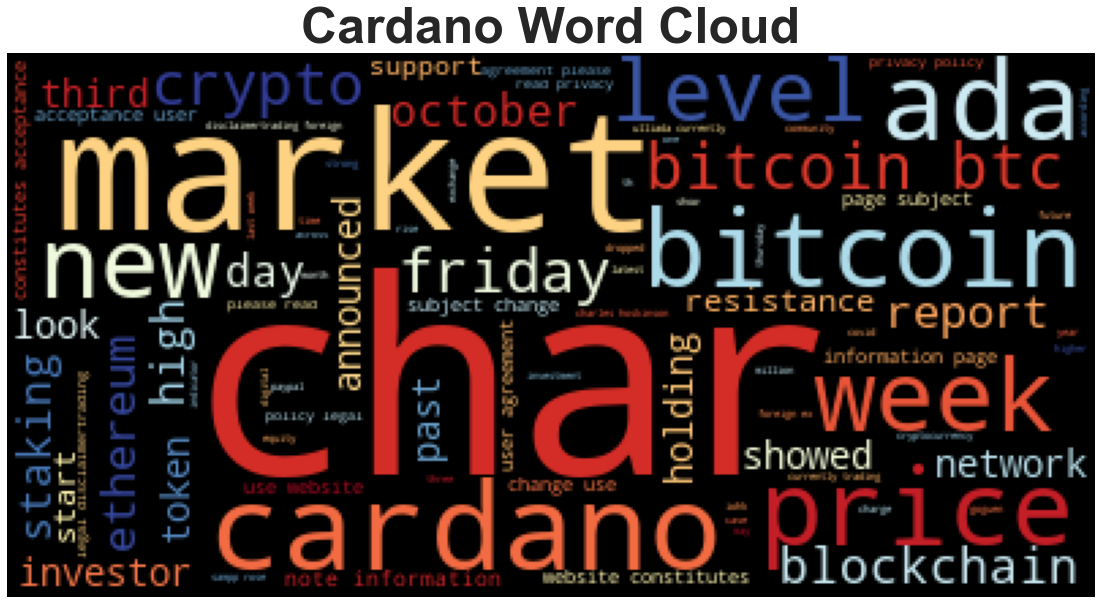

In [32]:
# Generate the Bitcoin word cloud
wordcloud = WordCloud(colormap="RdYlBu").generate(" ".join(flat_ada_tokens))
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Cardano Word Cloud", fontdict=fontdict)
plt.show()

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [56]:
import spacy
from spacy import displacy


In [57]:
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm

In [58]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [59]:
# Concatenate all of the bitcoin text together
flat_btc_text_str = " ".join(btc_df.text.to_list())
print(flat_btc_text_str)

NEW YORK (Reuters) - U.S. prosecutors on Thursday filed criminal charges accusing four founders and executives of BitMEX, one of the worlds largest cryptocurrency derivatives exchanges, of evading ru… [+2264 chars] BitMEX made itself available as a vehicle for money laundering and sanctions violations, the indictment released on Thursday said.
BitMEX has handled more than $1.5 billion of trades each day recent… [+963 chars] Reactions to Coinbase CEO Brian Armstrong's hard line against corporate activism at his company set off infighting among tech figures Wednesday who disagreed over whether Armstrong's stance was neces… [+4658 chars] NEW YORK (Reuters) - U.S. prosecutors on Thursday filed criminal charges accusing four founders and executives of BitMEX, one of the worlds largest cryptocurrency derivatives exchanges, of evading ru… [+2264 chars] By Reuters Staff
FRANKFURT (Reuters) - The European Central Bank must prepare to issue a digital euro to complement banknotes if and when it b

In [60]:
# Run the NER processor on all of the text
btc_doc = nlp(flat_btc_text_str)
btc_doc.user_data["title"] = "Bitcoin NER"
# Add a title to the document

In [61]:
# Render the visualization
displacy.render(btc_doc,style='ent')

spaCy tokenizes text in an entirely nondestructive manner... The underlying text does not change... spaCy does not explicitly break the original text into a list, but tokens can be accessed by index span.

spaCy provides syntactic parsing to show word usage, thus creating a dependency tree

In [72]:
# List all Entities
for ent in btc_doc.ents:
    print(ent.text, ent.label_, ent.lemma_, ent.text)

NEW YORK GPE NEW YORK NEW YORK
Reuters ORG Reuters Reuters
U.S. GPE U.S. U.S.
Thursday DATE Thursday Thursday
four CARDINAL four four
BitMEX ORG bitmex BitMEX
one CARDINAL one one
Thursday DATE Thursday Thursday
BitMEX ORG BitMEX BitMEX
more than $1.5 billion MONEY more than $ 1.5 billion more than $1.5 billion
each day DATE each day each day
+963 ORG +963 +963
Brian Armstrong's PERSON Brian Armstrong 's Brian Armstrong's
Wednesday DATE Wednesday Wednesday
Armstrong ORG Armstrong Armstrong
NEW YORK GPE NEW YORK NEW YORK
Reuters ORG Reuters Reuters
U.S. GPE U.S. U.S.
Thursday DATE Thursday Thursday
four CARDINAL four four
BitMEX ORG bitmex BitMEX
one CARDINAL one one
Reuters ORG Reuters Reuters
FRANKFURT ORG FRANKFURT FRANKFURT
Reuters ORG Reuters Reuters
The European Central Bank ORG the European Central Bank The European Central Bank
ECB ORG ECB ECB
Fabio Panetta PERSON Fabio Panetta Fabio Panetta
+1636 GPE +1636 +1636
US GPE US US
Donald Trump PERSON Donald Trump Donald Trump
Melania

---

In [73]:
from spacy import displacy

You can even traverse this parse tree

In [76]:
displacy.render(btc_doc, style='dep', options={'distance': 80}) 

In [77]:
from spacy.symbols import amod

In [82]:
spacy.explain("amod")

'adjectival modifier'

In [81]:
for token in btc_doc:
    if token.dep_ == 'amod':
        print(f"ADJ MODIFIER: {token.text} --> NOUN: {token.head}")

ADJ MODIFIER: criminal --> NOUN: charges
ADJ MODIFIER: largest --> NOUN: exchanges
ADJ MODIFIER: more --> NOUN: billion
ADJ MODIFIER: hard --> NOUN: line
ADJ MODIFIER: corporate --> NOUN: activism
ADJ MODIFIER: criminal --> NOUN: charges
ADJ MODIFIER: largest --> NOUN: exchanges
ADJ MODIFIER: digital --> NOUN: euro
ADJ MODIFIER: fucking --> NOUN: day
ADJ MODIFIER: digital --> NOUN: euro
ADJ MODIFIER: criminal --> NOUN: charges
ADJ MODIFIER: largest --> NOUN: exchanges
ADJ MODIFIER: bath --> NOUN: salts
ADJ MODIFIER: initial --> NOUN: offerings
ADJ MODIFIER: financial --> NOUN: watchdog
ADJ MODIFIER: retail --> NOUN: investors
ADJ MODIFIER: most --> NOUN: people
ADJ MODIFIER: financial --> NOUN: watchdog
ADJ MODIFIER: retail --> NOUN: investors
ADJ MODIFIER: most --> NOUN: pe
ADJ MODIFIER: +1603 --> NOUN: chars
ADJ MODIFIER: online --> NOUN: presence
ADJ MODIFIER: huge --> NOUN: returns
ADJ MODIFIER: first --> NOUN: quarters
ADJ MODIFIER: prominent --> NOUN: esports
ADJ MODIFIER: Bitcoi

### Named Entity Recognition

To see which tokens spaCy identifies as named entities... simply cycle through `btc_doc.ents`"

In [84]:
spacy.explain("GPE")

'Countries, cities, states'

In [83]:
for ent in btc_doc.ents:
    print(ent.text, ent.label_)

NEW YORK GPE
Reuters ORG
U.S. GPE
Thursday DATE
four CARDINAL
BitMEX ORG
one CARDINAL
Thursday DATE
BitMEX ORG
more than $1.5 billion MONEY
each day DATE
+963 ORG
Brian Armstrong's PERSON
Wednesday DATE
Armstrong ORG
NEW YORK GPE
Reuters ORG
U.S. GPE
Thursday DATE
four CARDINAL
BitMEX ORG
one CARDINAL
Reuters ORG
FRANKFURT ORG
Reuters ORG
The European Central Bank ORG
ECB ORG
Fabio Panetta PERSON
+1636 GPE
US GPE
Donald Trump PERSON
Melania Trump PERSON
the White House FAC
July 7, 2020 DATE
JIM WATSON/AFP ORG
Getty Images ORG
Friday DATE
Satoshi Nakaboto PERSON
Bitcoin BTC PERSON
Bitcoin PERSON
Today DATE
Satoshi Nakaboto PERSON
Bitcoin PERSON
FRANKFURT ORG
Reuters ORG
The European Central Bank ORG
ECB ORG
Fabio Panetta PERSON
Friday DATE
FILE ORG
NEW YORK GPE
Reuters ORG
U.S. GPE
Thursday DATE
four CARDINAL
BitMEX ORG
one CARDINAL
one CARDINAL
John McAfee PERSON
two CARDINAL
LONDON GPE
Reuters ORG
Britains NORP
Tuesday DATE
Bitcoin PERSON
Reuters ORG
LONDON GPE
Reuters ORG
Britains NO

## Scattertext

Scattertext is great for
- Visually inspecting text
- Comparing/Contrasting corpora

Jason Kessler's GitHub project for more information: [here](https://github.com/JasonKessler/scattertext).

In [88]:
import scattertext as st

In [91]:
btc_df.head()

text  \
date                                                            
2020-10-01  NEW YORK (Reuters) - U.S. prosecutors on Thurs...   
2020-10-01  BitMEX made itself available as a vehicle for ...   
2020-10-01  Reactions to Coinbase CEO Brian Armstrong's ha...   
2020-10-02  NEW YORK (Reuters) - U.S. prosecutors on Thurs...   
2020-10-02  By Reuters Staff\r\nFRANKFURT (Reuters) - The ...   

                      source  \
date                           
2020-10-01           Reuters   
2020-10-01    New York Times   
2020-10-01  Business Insider   
2020-10-02           Reuters   
2020-10-02           Reuters   

                                                          url  compound  \
date                                                                      
2020-10-01  https://uk.reuters.com/article/us-usa-crime-bi...   -0.7351   
2020-10-01  https://www.nytimes.com/2020/10/01/technology/...   -0.5267   
2020-10-01  https://www.businessinsider.com/twitter-ceo-ja...   -0.4019   
2020-10-02  https://in.reuters.com/article/usa-crime-bitme...   -0.7351   
2020-10-02  https://www.reuters.com/article/us-ecb-currenc...    0.0000   

            positive  neutral  negative  normalized  \
date                                                  
2020-10-01       0.0    0.789     0.211          -1   
2020-10-01       0.0    0.901     0.099          -1   
2020-10-01       0.0    0.887     0.113          -1   
2020-10-02       0.0    0.789     0.211          -1   
2020-10-02       0.0    1.000     0.000           0   

                                                       tokens sentiment  
date                                                                     
2020-10-01  new york  reuters    u s  prosecutors on thurs...  negative  
2020-10-01  bitmex made itself available as a vehicle for ...  negative  
2020-10-01  reactions to coinbase ceo brian armstrong s ha...  negative  
2020-10-02  new york  reuters    u s  prosecutors on thurs...  negative  
2020-10-02  by reuters staff\r\nfrankfurt  reuters    the ...  positive

In [103]:
corpus = st.CorpusFromPandas(btc_df,
                             category_col='sentiment',
                             text_col='tokens',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [102]:
#Doesn't work!!!
html = st.produce_scattertext_explorer(
        corpus,
        category='sentiment',
        category_name='negative',
        not_category_name='positive',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=btc_df['source'],
        )

In [105]:
open('scattertext_demo.html', 'wb').write(html.encode('utf-8'));

## Topic Modeling with Matrix Factorization

## Ethereum NER

In [40]:
# Concatenate all of the bitcoin text together
#
# https://spacy.io/usage/visualizers
# colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"ents": ["ORG"], "colors": colors}
# displacy.serve(doc, style="ent", options=options)
#
flat_eth_text_str = " ".join(eth_df.text.to_list())
#print(flat_eth_text_str)
eth_doc = nlp(flat_eth_text_str)
eth_doc.user_data["title"] = "Ethereum NER"
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}
displacy.render(eth_doc,style='ent', options=options)

In [41]:
# Run the NER processor on all of the text

# Add a title to the document

# List all Entities
for ent in eth_doc.ents:
    print(ent.text, ent.label_)

Sparkpool ORG
Taichi Network ORG
October DATE
CoinDesk ORG
Sparkpool ORG
Xin Xu PERSON
Reuters ORG
U.S. GPE
Wednesday DATE
U.S. GPE
Alvin H PERSON
BitMEXs DATE
U.S. GPE
DeFi PERSON
Ethereum LOC
Bitcoin PERSON
BTC ORG
around $10,582 MONEY
Reuters ORG
U.S. GPE
Wednesday DATE
SKALE ORG
Ethereum PRODUCT
two CARDINAL
Thursday DATE
Yuriko Nakao PERSON
Getty Images ORG
Yesterday DATE
today DATE
Bitcoin PERSON
Ethereum PRODUCT
second ORDINAL
Ethereum 2.0 PRODUCT
first ORDINAL
Spadina GPE
Danny Ryan PERSON
Satoshi Nakaboto PERSON
Bitcoin BTC PERSON
Bitcoin PERSON
Today DATE
Satoshi Nakaboto PERSON
Bitcoin PERSON
ETHOnline NORP
Friday afternoon TIME
Devcons ORG
Ethereum LOC
CFTC ORG
DOJ ORG
Thursday DATE
the derivatives exchange ORG
US GPE
Donald Trump PERSON
Melania Trump PERSON
the White House FAC
July 7, 2020 DATE
JIM WATSON/AFP ORG
Getty Images ORG
Friday DATE
Ethereum 2.0 PRODUCT
CoinDesk PRODUCT
Christine Kim PERSON
Cayman Nava PERSON
ChainSafe Systems and Alexey Akhunov ORG
+3614 CARDINAL

## Cardano NER

In [45]:
# Concatenate all of the bitcoin text together
#
# https://spacy.io/usage/visualizers
# colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"ents": ["ORG"], "colors": colors}
# displacy.serve(doc, style="ent", options=options)
#
flat_ada_text_str = " ".join(ada_df.text.to_list())
# print(flat_ada_text_str)
ada_doc = nlp(flat_ada_text_str)
ada_doc.user_data["title"] = "Cardano NER"
colors = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"ents": ["ORG"], "colors": colors}
displacy.render(ada_doc,style='ent', options=options)

In [46]:
# Run the NER processor on all of the text

# Add a title to the document

# List all Entities
for ent in ada_doc.ents:
    print(ent.text, ent.label_)

eToro ORG
Shopify ORG
Cardano ORG
Cardano ORG
ADA ORG
U.S. GPE
three CARDINAL
the past few days DATE
eToro ORG
14 million CARDINAL
today DATE
Cardano (AD ORG
Yesterday DATE
eToro ORG
14 million CARDINAL
Cardan NORP
Good afternoon TIME
S&amp;P 500 FAC
the week DATE
3,348 CARDINAL
Friday DATE
evening TIME
last week DATE
600 CARDINAL
the week DATE
3,348 CARDINAL
Friday DATE
evening TIME
last week DATE
600 CARDINAL
Bitcoin PERSON
11k MONEY
third ORDINAL
Last Thursday DATE
U.S. GPE
Bitcoin PERSON
11k MONEY
third ORDINAL
Last Thursday DATE
U.S. GPE
DeFi FAC
@cryptopigmedia ORG
Curve Finance PERSON
CRV ORG
93% PERCENT
DeFi WORK_OF_ART
Yearn Fina PERSON
ARK Investment Management LLC ORG
BTC ORG
$1-$5 trillion MONEY
first ORDINAL
second ORDINAL
June 2020 DATE
Tim Burgess PERSON
Rishi Sunak PERSON
millions CARDINAL
8 October DATE
Ravi Somaiya PERSON
Ethereum’s ORG
DappRadar PRODUCT
the third quarter of 2020 DATE
Ethereum ORG
96% PERCENT
DappRadar ORG
the third quarter of 2020 DATE
Ethereum ORG
9